In [75]:
import numpy as np
import segyio
import pywt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


In [77]:
def read_segy(path):
    with segyio.open(path, "r", ignore_geometry=False) as f:
        f.mmap()
        cube = segyio.tools.cube(f).transpose(2, 0, 1)  # (time, inline, xline)
        return cube.astype(np.float32)

image_cube = read_segy("TrainingData_Image.segy")
label_cube = read_segy("TrainingData_Labels.segy").astype(np.int64)
print("Loaded:", image_cube.shape, label_cube.shape)


Loaded: (1006, 590, 782) (1006, 590, 782)


In [78]:
# Replace your previous function with this robust version (single cell)
import numpy as np
from tqdm.notebook import tqdm
import pywt
import traceback

def compute_modwt_features_safe(cube, wavelet='db4', level=4, verbose=True):
    """
    For each trace in cube (Nt, Ni, Nj):
      - compute wavedec(trace, wavelet, level=level)
      - reconstruct each detail band and approximation to full length Nt using waverec
      - trim or pad each reconstructed signal to exact length Nt
    Returns:
      features: ndarray (Nt, Ni, Nj, Lout) where Lout = level + 1
                ordering: features[..., 0] = D1 (finest), ..., features[..., level-1] = DL (coarsest),
                          features[..., level] = A (approximation/coarse)
    Notes:
      - This is a DWT-based reconstruction fallback (not true MODWT) but yields full-length multi-scale features.
      - Might be slower for very large cubes; test on a small subset first.
    """
    try:
        cube = np.asarray(cube)
        if cube.ndim != 3:
            raise ValueError(f"Expect cube shape (Nt,Ni,Nj). Got {cube.shape}")
        Nt, Ni, Nj = cube.shape

        # safe check on allowed decomposition level
        max_allowed = pywt.dwt_max_level(Nt, pywt.Wavelet(wavelet).dec_len)
        if max_allowed < 1:
            raise ValueError(f"Trace length {Nt} too short for wavelet '{wavelet}' (max_allowed={max_allowed})")
        L = min(level, max_allowed)
        if L < level and verbose:
            print(f"Requested level {level} reduced to {L} (max allowed for Nt={Nt}, wavelet='{wavelet}')")

        Lout = L + 1  # L details + 1 approximation
        out = np.zeros((Nt, Ni, Nj, Lout), dtype=np.float32)

        # iterate through cube and compute per-trace reconstructions
        for i in tqdm(range(Ni), desc="Inline"):
            for j in range(Nj):
                trace = cube[:, i, j]
                if np.isnan(trace).any():
                    out[:, i, j, :] = 0.0
                    continue

                # compute decimated wavelet decomposition
                coeffs = pywt.wavedec(trace, wavelet, level=L)

                # We'll reconstruct: details (cD1..cDL) and approximation (cA_L)
                # coeffs layout: [cA_L, cD_L, cD_{L-1}, ..., cD1]
                num_coeffs = len(coeffs)  # should be L + 1

                # For each position p in 1..L (coeffs[1]..coeffs[L]) reconstruct single detail
                # We'll collect reconstructed arrays in list 'recon_list' but in ordering D1..DL then approximation
                recon_list = [None] * (Lout)  # will hold D1..DL, A

                # reconstruct each detail band (p from 1..L)
                for p in range(1, num_coeffs):  # p==1 => cD_L (coarsest); p==num_coeffs-1 => cD1 (finest)
                    # build tmp coeffs list with zeros except at index p
                    tmp = [np.zeros_like(coeffs[0])] + [np.zeros_like(c) for c in coeffs[1:]]
                    tmp[p] = coeffs[p].copy()
                    recon = pywt.waverec(tmp, wavelet)

                    # ensure length Nt by trimming or padding
                    if recon.shape[0] >= Nt:
                        recon = recon[:Nt]
                    else:
                        recon = np.pad(recon, (0, Nt - recon.shape[0]), mode='constant', constant_values=0.0)

                    # map p -> detail index: p == num_coeffs-1 -> D1 (index 0), p==1 -> DL (index L-1)
                    detail_idx = (num_coeffs - 1) - p  # 0-based index for D1..DL
                    recon_list[detail_idx] = recon.astype(np.float32)

                # reconstruct approximation: zero out details, keep coeffs[0]
                tmpA = [coeffs[0].copy()] + [np.zeros_like(c) for c in coeffs[1:]]
                reconA = pywt.waverec(tmpA, wavelet)
                if reconA.shape[0] >= Nt:
                    reconA = reconA[:Nt]
                else:
                    reconA = np.pad(reconA, (0, Nt - reconA.shape[0]), mode='constant', constant_values=0.0)
                recon_list[-1] = reconA.astype(np.float32)  # last slot is approximation

                # final safety check: fill any None with zeros (shouldn't happen)
                for k in range(Lout):
                    if recon_list[k] is None:
                        recon_list[k] = np.zeros(Nt, dtype=np.float32)

                # stack along last axis (Nt,) -> shape (Nt, Lout)
                stacked = np.stack(recon_list, axis=-1)  # (Nt, Lout)
                out[:, i, j, :] = stacked

        if verbose:
            print("compute_modwt_features_safe done. Output shape:", out.shape)
        return out

    except Exception:
        print("Exception inside compute_modwt_features_safe:")
        traceback.print_exc()
        raise


In [79]:
# test on a small subset to be safe
subset = image_cube[:, :10, :10]   # choose small block
features_small = compute_modwt_features_safe(subset, wavelet='db4', level=4, verbose=True)
print("features_small.shape:", features_small.shape)  # expected (Nt, 10, 10, <=5)


Inline:   0%|          | 0/10 [00:00<?, ?it/s]

compute_modwt_features_safe done. Output shape: (1006, 10, 10, 5)
features_small.shape: (1006, 10, 10, 5)


In [80]:
# full cube (may take long and use memory)
features_full = compute_modwt_features_safe(image_cube, wavelet='db4', level=4, verbose=True)
print("features_full.shape:", features_full.shape)


Inline:   0%|          | 0/590 [00:00<?, ?it/s]

compute_modwt_features_safe done. Output shape: (1006, 590, 782, 5)
features_full.shape: (1006, 590, 782, 5)


# save to memmap and free RAM

In [83]:
# --- Step 1: Save features_full to disk (memmap) ---
import numpy as np
import os, gc

memfile = "features_full_memmap.npy"

if os.path.exists(memfile):
    os.remove(memfile) 

print("Saving features_full to memmapped .npy file (this may take a few minutes)...")
fp = np.lib.format.open_memmap(memfile, mode='w+', dtype=features_full.dtype, shape=features_full.shape)
fp[:] = features_full[:]   # write full cube to disk
del features_full
gc.collect()
print("Memmap saved successfully! Shape:", fp.shape)


Saving features_full to memmapped .npy file (this may take a few minutes)...
Memmap saved successfully! Shape: (1006, 590, 782, 5)


In [84]:
# --- Step 2: Open memmap (read-only mode) ---
features_mm = np.load("features_full_memmap.npy", mmap_mode='r')
print("Memmap opened:", features_mm.shape, features_mm.dtype)


Memmap opened: (1006, 590, 782, 5) float32


In [85]:
# --- Step 3: Define LazyPatchDataset class ---
import torch
from torch.utils.data import Dataset

class LazyPatchDataset(Dataset):
    def __init__(self, features_memmap, label_cube, centers, patch=3):
        self.features = features_memmap
        self.labels = label_cube
        self.centers = centers
        self.patch = patch
        self.r = patch // 2

    def __len__(self):
        return len(self.centers)

    def __getitem__(self, idx):
        i, j = self.centers[idx]
        r = self.r
        # read small 3x3 patch
        patch = self.features[:, i-r:i+r+1, j-r:j+r+1, :]   # (Nt,3,3,5)
        patch = np.transpose(patch, (0, 3, 1, 2))           # (Nt,5,3,3)
        feats = patch.reshape(patch.shape[0], -1).astype(np.float32)  # (Nt,45)
        labs = self.labels[:, i, j].astype(np.int64)
        return torch.from_numpy(feats), torch.from_numpy(labs - 1)


In [86]:
# --- Step 4: Build center list and random splits ---
Nt, Ni, Nj, Lout = features_mm.shape
centers = [(ii, jj) for ii in range(1, Ni-1) for jj in range(1, Nj-1)]
print("Total patch centers:", len(centers))

import random
random.shuffle(centers)
n_train = int(0.7 * len(centers))
n_val   = int(0.1 * len(centers))

train_centers = centers[:n_train]
val_centers   = centers[n_train:n_train+n_val]
test_centers  = centers[n_train+n_val:]

print("Train:", len(train_centers), "Val:", len(val_centers), "Test:", len(test_centers))


Total patch centers: 458640
Train: 321048 Val: 45864 Test: 91728


In [87]:
# --- Step 5: Create datasets and dataloaders ---
batch_size = 8  # start small (use 4 if kernel still dies)

train_ds = LazyPatchDataset(features_mm, label_cube, train_centers)
val_ds   = LazyPatchDataset(features_mm, label_cube, val_centers)
test_ds  = LazyPatchDataset(features_mm, label_cube, test_centers)

from torch.utils.data import DataLoader
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=0)

xb, yb = next(iter(train_loader))
print("Batch shapes:", xb.shape, yb.shape)


Batch shapes: torch.Size([8, 1006, 45]) torch.Size([8, 1006])


In [ ]:
'''# ==========================================================
# STEP 6 — Optimized Full-Data Training & Evaluation
# ==========================================================
import torch, torch.nn as nn, torch.optim as optim, numpy as np, time, os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

device = torch.device('mps' if (hasattr(torch.backends,"mps") and torch.backends.mps.is_available())
                      else ('cuda' if torch.cuda.is_available() else 'cpu'))
print(f"🧠 Using device: {device}")

# ---------- Model ----------
class BiLSTM_MATLAB(nn.Module):
    def __init__(self, input_size=45, hidden1=50, hidden2=50, num_classes=6):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size, hidden1, batch_first=True, bidirectional=True)
        self.ln1   = nn.LayerNorm(hidden1*2)
        self.lstm2 = nn.LSTM(hidden1*2, hidden2, batch_first=True, bidirectional=True)
        self.ln2   = nn.LayerNorm(hidden2*2)
        self.fc    = nn.Linear(hidden2*2, num_classes)
    def forward(self, x):
        o,_ = self.lstm1(x)
        o = self.ln1(o)
        o,_ = self.lstm2(o)
        o = self.ln2(o)
        return self.fc(o)

model = BiLSTM_MATLAB().to(device)

# ---------- Training setup ----------
epochs = 5
batch_size = train_loader.batch_size
lr, weight_decay = 1e-3, 1e-3
class_weights = torch.tensor([1,1,1,2,8,8],dtype=torch.float32).to(device)

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss(weight=class_weights)
grad_clip = 5.0
ckpt_path = "netLstm_full_checkpoint.pth"

# ---------- Resume if checkpoint exists ----------
start_epoch = 0
if os.path.exists(ckpt_path):
    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt["model_state"])
    optimizer.load_state_dict(ckpt["opt_state"])
    start_epoch = ckpt["epoch"]+1
    print(f"🔄 Resumed from epoch {start_epoch}")

# ---------- Training ----------
for epoch in range(start_epoch, epochs):
    model.train()
    running_loss = 0.0
    n_batches = len(train_loader)
    t0 = time.time()
    for i,(xb,yb) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)):
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        B,S,C = logits.shape
        loss = criterion(logits.view(B*S,C), yb.view(B*S))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        running_loss += loss.item()
        # progress every 100 batches
        if (i+1) % 100 == 0 or (i+1)==n_batches:
            avg_loss = running_loss/(i+1)
            print(f"  batch {i+1:6d}/{n_batches}  loss={avg_loss:.4f}")
        # checkpoint every 1000 batches
        if (i+1) % 1000 == 0:
            torch.save({"epoch":epoch,
                        "model_state":model.state_dict(),
                        "opt_state":optimizer.state_dict()},
                        ckpt_path)
    # end epoch checkpoint
    torch.save({"epoch":epoch,
                "model_state":model.state_dict(),
                "opt_state":optimizer.state_dict()},
                ckpt_path)
    print(f"✅ Epoch {epoch+1} finished in {(time.time()-t0)/60:.1f} min, avg loss={running_loss/n_batches:.4f}")

# ---------- Final save ----------
torch.save({"model_state":model.state_dict()}, "netLstm_final_full.pth")
print("💾 Saved final model netLstm_final_full.pth")

# ==========================================================
# Evaluation on full test set (batched for speed)
# ==========================================================
print("Evaluating test set ...")
model.eval()
all_preds, all_trues = [], []
with torch.no_grad():
    for xb,yb in tqdm(test_loader, desc="Inference", leave=False):
        xb = xb.to(device)
        logits = model(xb)
        preds = logits.argmax(dim=2).cpu().numpy().ravel()
        trues = yb.numpy().ravel()
        all_preds.append(preds)
        all_trues.append(trues)

all_preds = np.concatenate(all_preds)
all_trues = np.concatenate(all_trues)
print("Total test samples:", len(all_trues))

# ---------- Confusion matrix ----------
cm = confusion_matrix(all_trues, all_preds, labels=[0,1,2,3,4,5])
disp = ConfusionMatrixDisplay(cm, display_labels=[1,2,3,4,5,6])
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, cmap='Blues', colorbar=True)
plt.title("Confusion Matrix (Test Set)")
plt.show()

# ---------- Per-class accuracy ----------
per_class_acc = cm.diagonal() / (cm.sum(axis=1)+1e-9)
for i,a in enumerate(per_class_acc,1):
    print(f"Class {i} accuracy: {a:.3f}")
'''

print(f"Epoch {epoch+1} done at {datetime.datetime.now().strftime('%H:%M:%S')}", flush=True)


Using device: mps
Using existing model object.
Mixed precision: using MPS autocast (no GradScaler)

Starting epoch 1/1  -- 40131 batches


Epoch 1:   0%|          | 0/40131 [00:00<?, ?it/s]

  batch 100/40131  avg_loss=0.2930  elapsed=5.4min
  batch 200/40131  avg_loss=0.2955  elapsed=10.9min
  batch 300/40131  avg_loss=0.2903  elapsed=16.2min
  batch 400/40131  avg_loss=0.2854  elapsed=21.5min
  batch 500/40131  avg_loss=0.2865  elapsed=26.8min
  batch 600/40131  avg_loss=0.2862  elapsed=40.5min
  batch 700/40131  avg_loss=0.2851  elapsed=45.9min
  batch 800/40131  avg_loss=0.2824  elapsed=51.0min
  batch 900/40131  avg_loss=0.2824  elapsed=56.3min
  batch 1000/40131  avg_loss=0.2811  elapsed=61.7min
  batch 1100/40131  avg_loss=0.2795  elapsed=67.1min
  batch 1200/40131  avg_loss=0.2784  elapsed=72.5min
  batch 1300/40131  avg_loss=0.2777  elapsed=77.9min
  batch 1400/40131  avg_loss=0.2766  elapsed=83.4min
  batch 1500/40131  avg_loss=0.2760  elapsed=96.0min
  batch 1600/40131  avg_loss=0.2751  elapsed=133.7min
  batch 1700/40131  avg_loss=0.2746  elapsed=358.8min
  batch 1800/40131  avg_loss=0.2746  elapsed=587.5min
  batch 1900/40131  avg_loss=0.2735  elapsed=638.2min

Inference:   0%|          | 0/91728 [00:00<?, ?it/s]

Total test time-steps: 92278368


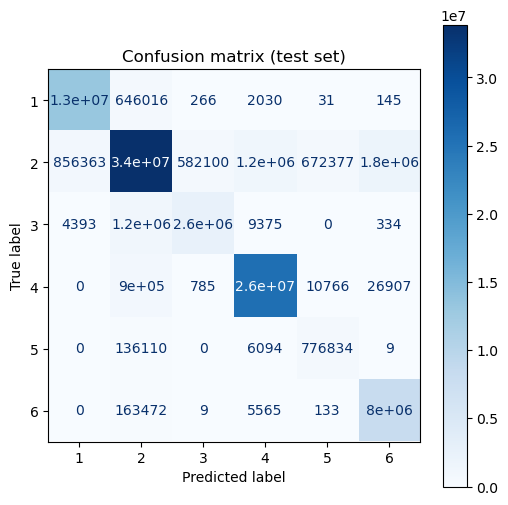

Class 1 accuracy: 0.953
Class 2 accuracy: 0.869
Class 3 accuracy: 0.691
Class 4 accuracy: 0.965
Class 5 accuracy: 0.845
Class 6 accuracy: 0.979


In [97]:
# ---------------------------
# QUICK: Train exactly 1 epoch + evaluate (optional mixed precision)
# Paste this AFTER you've created train_loader/val_loader/test_loader
# ---------------------------
import time, os
import torch, torch.nn as nn, torch.optim as optim
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ---------- CONFIG ----------
RUN_EPOCHS = 1           # set to 1 for the quick/full-data pass you requested
BATCH_PRINT = 100        # print status every N batches
CKPT_PATH = "netLstm_one_epoch_checkpoint.pth"
USE_MIXED_PRECISION = True   # try enabling AMP (autocast). Set False to disable.

# ---------- device ----------
device = torch.device('mps' if (hasattr(torch.backends,"mps") and torch.backends.mps.is_available())
                      else ('cuda' if torch.cuda.is_available() else 'cpu'))
print("Using device:", device)

# ---------- model (reuse if present) ----------
try:
    model
    print("Using existing model object.")
except NameError:
    # If you don't have model defined, define the same BiLSTM used before:
    class BiLSTM_MATLAB(nn.Module):
        def __init__(self, input_size=45, hidden1=50, hidden2=50, num_classes=6):
            super().__init__()
            self.lstm1 = nn.LSTM(input_size, hidden1, batch_first=True, bidirectional=True)
            self.ln1   = nn.LayerNorm(hidden1*2)
            self.lstm2 = nn.LSTM(hidden1*2, hidden2, batch_first=True, bidirectional=True)
            self.ln2   = nn.LayerNorm(hidden2*2)
            self.fc    = nn.Linear(hidden2*2, num_classes)
        def forward(self, x):
            o,_ = self.lstm1(x)
            o = self.ln1(o)
            o,_ = self.lstm2(o)
            o = self.ln2(o)
            return self.fc(o)
    model = BiLSTM_MATLAB().to(device)

# ---------- training hyperparams (same as MATLAB mapping) ----------
lr = 1e-3
weight_decay = 1e-3
class_weights = torch.tensor([1.,1.,1.,2.,8.,8.], dtype=torch.float32).to(device)

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# ---#------- AMP setup ----------
use_amp = False
scaler = None
if USE_MIXED_PRECISION:
    if device.type == "cuda":
        from torch.cuda.amp import autocast, GradScaler
        scaler = GradScaler()
        use_amp = True
        print("Mixed precision: using CUDA autocast + GradScaler")
    elif device.type == "mps":
        # MPS supports autocast in recent PyTorch builds; GradScaler not fully supported on MPS.
        try:
            from torch import autocast  # autocast is available as torch.autocast in some builds
            use_amp = True
            print("Mixed precision: using MPS autocast (no GradScaler)")
        except Exception:
            use_amp = False
            print("Mixed precision requested but autocast not available for this device. Running in fp32.")
    else:
        use_amp = False
        print("Mixed precision requested but not supported on this device - running fp32.")

# ---------- optionally resume checkpoint ----------
start_epoch = 0
if os.path.exists(CKPT_PATH):
    ckpt = torch.load(CKPT_PATH, map_location=device)
    model.load_state_dict(ckpt.get("model_state", ckpt))
    optimizer.load_state_dict(ckpt.get("opt_state", optimizer.state_dict()))
    start_epoch = ckpt.get("epoch", 0)
    print("Resumed checkpoint at epoch", start_epoch)

# ---------- Run 1 epoch (or RUN_EPOCHS) ----------
model.train()
global_start = time.time()
for epoch in range(start_epoch, start_epoch + RUN_EPOCHS):
    epoch_start = time.time()
    running_loss = 0.0
    n_batches = len(train_loader)
    print(f"\nStarting epoch {epoch+1}/{start_epoch + RUN_EPOCHS}  -- {n_batches} batches")
    pbar = tqdm(enumerate(train_loader, start=1), total=n_batches, desc=f"Epoch {epoch+1}", leave=True)
    for batch_idx, (xb, yb) in pbar:
        xb = xb.to(device, non_blocking=True)   # shape (B, S, 45)
        yb = yb.to(device, non_blocking=True)   # shape (B, S)
        optimizer.zero_grad()

        if use_amp and device.type == "cuda":
            # CUDA + GradScaler path
            with torch.cuda.amp.autocast():
                logits = model(xb)                            # (B, S, C)
                B,S,C = logits.shape
                loss = criterion(logits.view(B*S, C), yb.view(B*S))
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            scaler.step(optimizer)
            scaler.update()
        elif use_amp and device.type == "mps":
            # MPS autocast (no GradScaler)
            with torch.autocast(device_type="mps", dtype=torch.float16):
                logits = model(xb)
                B,S,C = logits.shape
                loss = criterion(logits.view(B*S, C), yb.view(B*S))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
        else:
            # plain fp32
            logits = model(xb)
            B,S,C = logits.shape
            loss = criterion(logits.view(B*S, C), yb.view(B*S))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()

        running_loss += loss.item()
        if batch_idx % BATCH_PRINT == 0 or batch_idx == n_batches:
            avg_loss = running_loss / batch_idx
            pbar.set_postfix({"batch":f"{batch_idx}/{n_batches}", "loss":f"{avg_loss:.4f}"})
            print(f"  batch {batch_idx}/{n_batches}  avg_loss={avg_loss:.4f}  elapsed={ (time.time()-epoch_start)/60:.1f}min")

        # checkpoint lightly every 2000 batches to be safe
        if batch_idx % 2000 == 0:
            torch.save({"epoch": epoch, "batch_idx": batch_idx,
                        "model_state": model.state_dict(),
                        "opt_state": optimizer.state_dict()}, CKPT_PATH)

    # end epoch
    torch.save({"epoch": epoch, "model_state": model.state_dict(),
                "opt_state": optimizer.state_dict()}, CKPT_PATH)
    print(f"✅ Finished epoch {epoch+1} in {(time.time()-epoch_start)/60:.2f} minutes. avg loss={running_loss/n_batches:.4f}")

print("Total training time:", (time.time()-global_start)/60, "minutes")
# ---------------------------
# Evaluate right away on test set
# ---------------------------
model.eval()
all_preds, all_trues = [], []
with torch.no_grad():
    for xb, yb in tqdm(test_loader, desc="Inference", leave=True):
        xb = xb.to(device)
        logits = model(xb)                      # (B, S, C)
        preds = logits.argmax(dim=2).cpu().numpy().ravel()
        trues = yb.numpy().ravel()
        all_preds.append(preds)
        all_trues.append(trues)

all_preds = np.concatenate(all_preds)
all_trues = np.concatenate(all_trues)
print("Total test time-steps:", len(all_trues))

cm = confusion_matrix(all_trues, all_preds, labels=[0,1,2,3,4,5])
disp = ConfusionMatrixDisplay(cm, display_labels=[1,2,3,4,5,6])
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, cmap='Blues', colorbar=True)
plt.title("Confusion matrix (test set)")
plt.show()

per_class_acc = cm.diagonal() / (cm.sum(axis=1) + 1e-9)
for i, acc in enumerate(per_class_acc, start=1):
    print(f"Class {i} accuracy: {acc:.3f}")


# confusion matrix (column-normalized)

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def short_confmat(trues, preds, class_names=['1','2','3','4','5','6'], save=None):
    t = np.asarray(trues).ravel(); p = np.asarray(preds).ravel()
    if t.min()==1: t-=1
    if p.min()==1: p-=1
    cm = confusion_matrix(t, p, labels=range(len(class_names))).astype(float)
    # column-normalize
    with np.errstate(divide='ignore', invalid='ignore'):
        cm = cm / cm.sum(axis=0, keepdims=True)
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, cmap='Blues', vmin=0, vmax=1)
    ax.set_xticks(range(len(class_names))); ax.set_yticks(range(len(class_names)))
    ax.set_xticklabels(class_names); ax.set_yticklabels(class_names)
    ax.set_xlabel('Predicted'); ax.set_ylabel('True'); ax.set_title('Confusion (col-normalized)')
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j,i,f"{cm[i,j]:.2f}", ha='center', va='center', color='white' if cm[i,j]>0.5 else 'black')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    if save: plt.savefig(save, dpi=300, bbox_inches='tight')
    return fig, ax


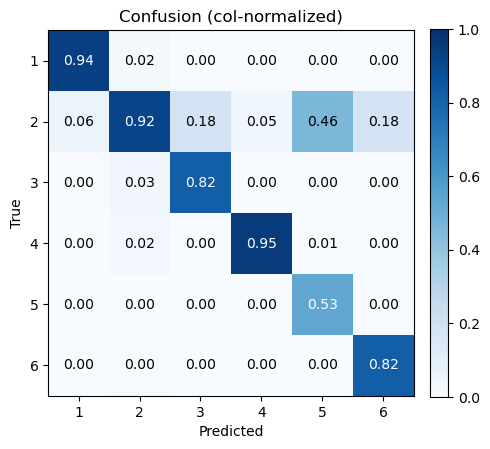

In [122]:
fig,_ = short_confmat(all_trues, all_preds, save='confusion_short.png')


# per class accuracy

Per-class accuracy: [0.94 0.92 0.82 0.95 0.53 0.82]


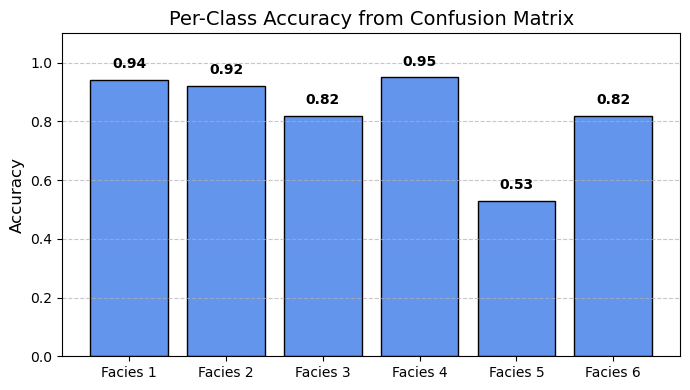

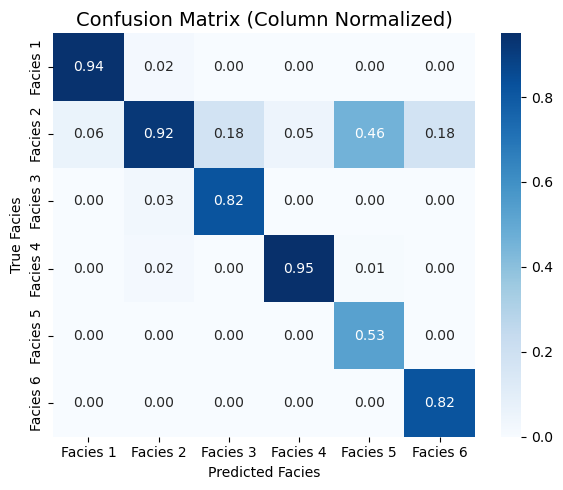

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# === Step 1: Define your confusion matrix values (from your image) ===
cm = np.array([
    [0.94, 0.02, 0.00, 0.00, 0.00, 0.00],
    [0.06, 0.92, 0.18, 0.05, 0.46, 0.18],
    [0.00, 0.03, 0.82, 0.00, 0.00, 0.00],
    [0.00, 0.02, 0.00, 0.95, 0.01, 0.00],
    [0.00, 0.00, 0.00, 0.00, 0.53, 0.00],
    [0.00, 0.00, 0.00, 0.00, 0.00, 0.82]
])

classes = ['Facies 1','Facies 2','Facies 3','Facies 4','Facies 5','Facies 6']

# === Step 2: Compute per-class accuracy (diagonal values) ===
per_class_acc = np.diag(cm)
print("Per-class accuracy:", per_class_acc)

# === Step 3: Plot Bar Chart of Accuracy ===
plt.figure(figsize=(7,4))
bars = plt.bar(classes, per_class_acc, color='cornflowerblue', edgecolor='black')
plt.title('Per-Class Accuracy from Confusion Matrix', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar, acc in zip(bars, per_class_acc):
    plt.text(bar.get_x() + bar.get_width()/2, acc + 0.03, f"{acc:.2f}",
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# === Step 4 (Optional): Plot Heatmap for same matrix ===
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, cmap='Blues', fmt=".2f", xticklabels=classes, yticklabels=classes, cbar=True)
plt.title('Confusion Matrix (Column Normalized)', fontsize=14)
plt.xlabel('Predicted Facies')
plt.ylabel('True Facies')
plt.tight_layout()
plt.show()


In [21]:
fig,_ = short_perclass(all_trues, all_preds, save='perclass_short.png')


NameError: name 'all_trues' is not defined

# testing

Test cube shape: (1006, 251, 782)
Extracting features ...
Features shape: (1006, 251, 782, 5)
Prediction complete: (1006, 251, 782)


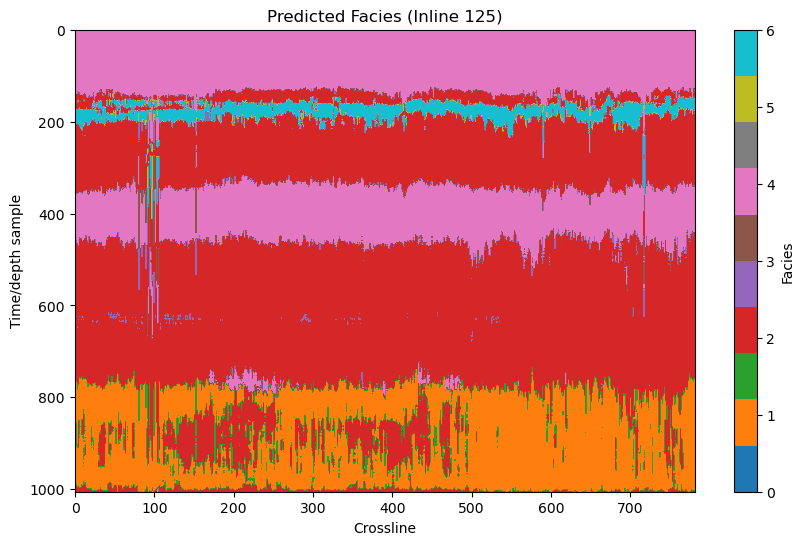

Saved facies predictions to facies_pred_cube.npy


In [131]:
import numpy as np
import torch
import segyio
import pywt
import matplotlib.pyplot as plt

# -------------------------------
# 1️⃣ Load test SEGY data
# -------------------------------
def read_segy(path):
    with segyio.open(path, "r", ignore_geometry=False) as f:
        f.mmap()
        cube = segyio.tools.cube(f).transpose(2, 0, 1)  # (time, inline, crossline)
        return cube.astype(np.float32)

test_cube = read_segy("TestData_Image1.segy")
print("Test cube shape:", test_cube.shape)

# -------------------------------
# 2️⃣ Compute wavelet (MODWT-like) features
# -------------------------------
def compute_features(cube, wavelet='db4', level=4):
    Nt, Ni, Nj = cube.shape
    Lout = level + 1
    out = np.zeros((Nt, Ni, Nj, Lout), dtype=np.float32)
    for i in range(Ni):
        for j in range(Nj):
            trace = cube[:, i, j]
            coeffs = pywt.wavedec(trace, wavelet, level=level)
            rec = []
            for p in range(1, len(coeffs)):
                tmp = [np.zeros_like(c) for c in coeffs]
                tmp[p] = coeffs[p].copy()
                r = pywt.waverec(tmp, wavelet)
                rec.append(r[:Nt])
            # Approximation
            tmpA = [coeffs[0].copy()] + [np.zeros_like(c) for c in coeffs[1:]]
            rA = pywt.waverec(tmpA, wavelet)
            rec.append(rA[:Nt])
            out[:, i, j, :] = np.stack(rec, axis=-1)
    return out

print("Extracting features ...")
features_test = compute_features(test_cube, wavelet='db4', level=4)
print("Features shape:", features_test.shape)  # (Nt, Ni, Nj, 5)

# -------------------------------
# 3️⃣ Load trained BiLSTM model
# -------------------------------
class BiLSTM_MATLAB(torch.nn.Module):
    def __init__(self, input_size=45, hidden1=50, hidden2=50, num_classes=6):
        super().__init__()
        self.lstm1 = torch.nn.LSTM(input_size, hidden1, batch_first=True, bidirectional=True)
        self.ln1   = torch.nn.LayerNorm(hidden1*2)
        self.lstm2 = torch.nn.LSTM(hidden1*2, hidden2, batch_first=True, bidirectional=True)
        self.ln2   = torch.nn.LayerNorm(hidden2*2)
        self.fc    = torch.nn.Linear(hidden2*2, num_classes)
    def forward(self, x):
        o,_ = self.lstm1(x)
        o = self.ln1(o)
        o,_ = self.lstm2(o)
        o = self.ln2(o)
        return self.fc(o)

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
model = BiLSTM_MATLAB().to(device)
model.load_state_dict(torch.load("netLstm_one_epoch_checkpoint.pth", map_location=device)["model_state"])
model.eval()

# -------------------------------
# 4️⃣ Predict facies for test cube
# -------------------------------
Nt, Ni, Nj, Lout = features_test.shape
facies_pred = np.zeros((Nt, Ni, Nj), dtype=np.int32)

with torch.no_grad():
    for i in range(1, Ni-1):
        for j in range(1, Nj-1):
            patch = features_test[:, i-1:i+2, j-1:j+2, :]  # (Nt,3,3,5)
            patch = np.transpose(patch, (0,3,1,2)).reshape(Nt, -1)  # (Nt,45)
            x = torch.from_numpy(patch[None,:,:].astype(np.float32)).to(device)
            logits = model(x)
            pred = logits.argmax(dim=2).cpu().numpy().ravel()
            facies_pred[:, i, j] = pred + 1  # back to labels 1..6

print("Prediction complete:", facies_pred.shape)

# -------------------------------
# 5️⃣ Plot example inline slice
# -------------------------------
iline_idx = Ni // 2  # middle inline
plt.figure(figsize=(10,6))
plt.imshow(facies_pred[:, iline_idx, :], aspect='auto', cmap='tab10')
plt.title(f"Predicted Facies (Inline {iline_idx})")
plt.xlabel("Crossline")
plt.ylabel("Time/depth sample")
plt.colorbar(label="Facies")
plt.show()

# -------------------------------
# 6️⃣ Save facies cube if needed
# -------------------------------
np.save("facies_pred_cube.npy", facies_pred)
print("Saved facies predictions to facies_pred_cube.npy")


In [4]:
import segyio
import numpy as np

def read_segy(path):
    with segyio.open(path, "r", ignore_geometry=False) as f:
        f.mmap()
        cube = segyio.tools.cube(f).transpose(2, 0, 1)  # (time, inline, xline)
        return cube.astype(np.float32)

# ✅ Read seismic and label cubes
image_cube = read_segy("TrainingData_Image.segy")
label_cube = read_segy("TrainingData_Labels.segy").astype(np.int64)

print("Loaded:", image_cube.shape, label_cube.shape)


Loaded: (1006, 590, 782) (1006, 590, 782)


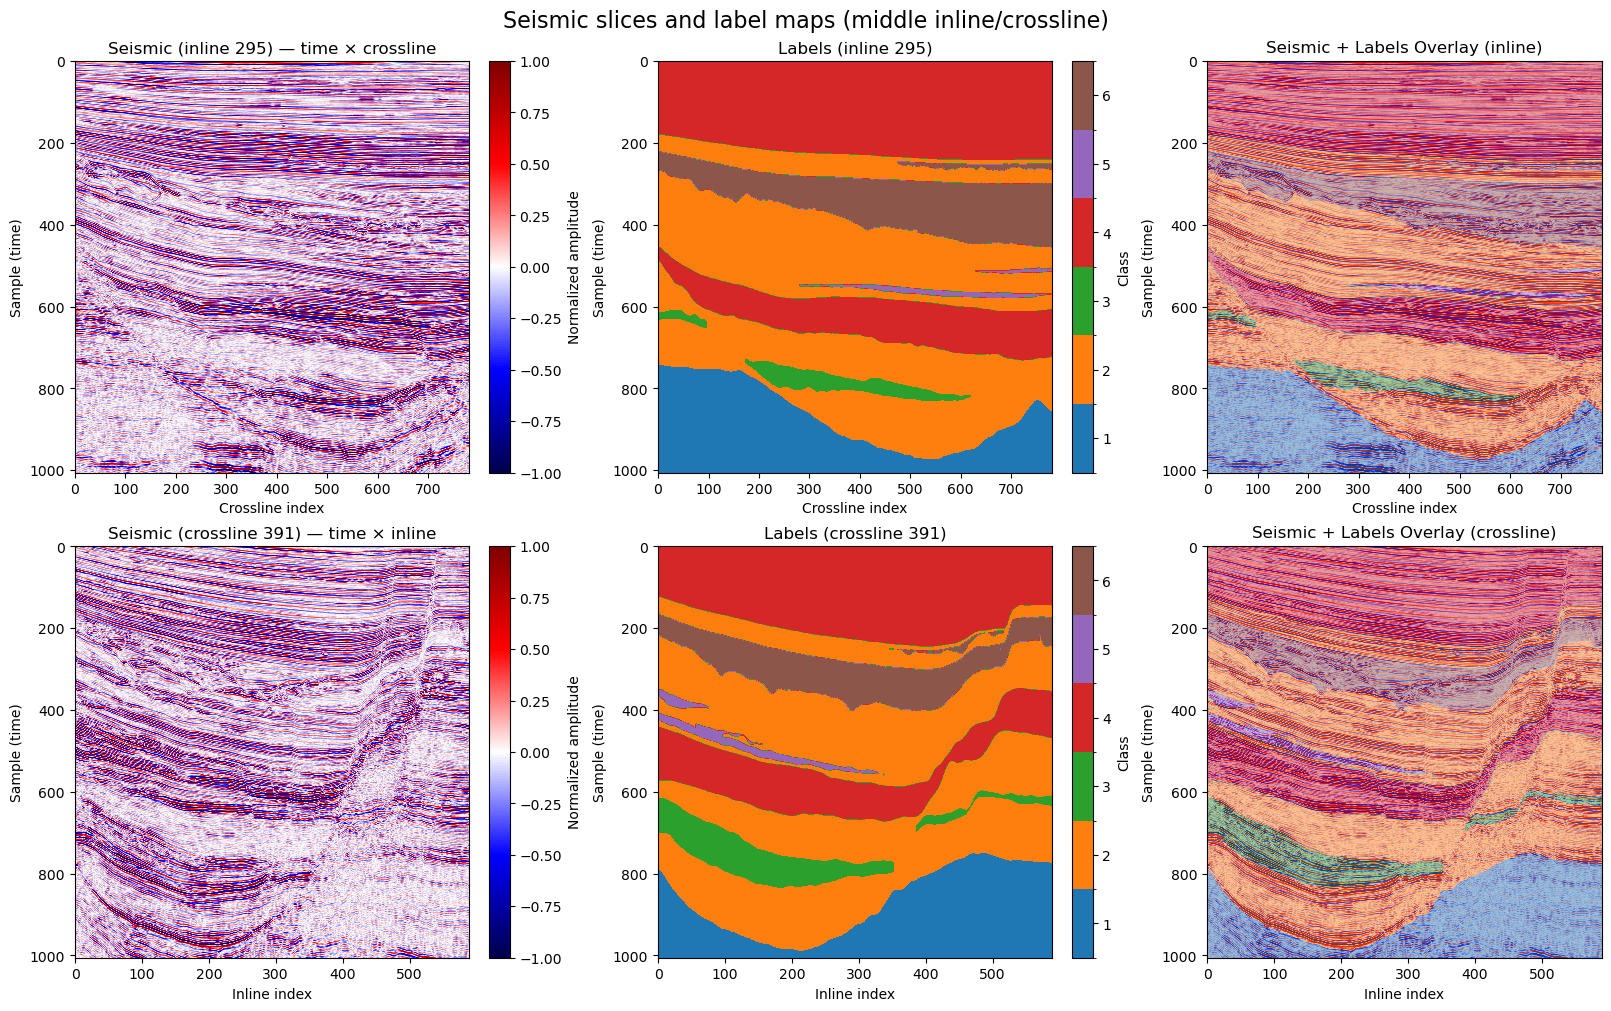

Saved figure to seismic_label_slices.png


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# --- choose slices (middle by default) ---
Nt, Ni, Nj = image_cube.shape
inline_idx = Ni // 2     # middle inline
xline_idx  = Nj // 2     # middle crossline

# seismic slices: shape (Nt, Ncross) to plot as image (time down)
seis_inline = image_cube[:, inline_idx, :]   # (Nt, Nj)  -> time x crossline
seis_xline  = image_cube[:, :, xline_idx]   # (Nt, Ni)  -> time x inline

# label slices (labels assumed 1..6). If labels are zero-based adjust accordingly.
lab_inline = label_cube[:, inline_idx, :]   # (Nt, Nj)
lab_xline  = label_cube[:, :, xline_idx]    # (Nt, Ni)

# --- scale seismic for display: robust percentile clipping ---
pmin, pmax = np.percentile(image_cube, [2, 98])
def norm_seis(arr):
    return np.clip((arr - pmin) / (pmax - pmin), 0.0, 1.0) * 2 - 1  # scale to [-1,1] for 'seismic' cmap

# --- discrete colormap for labels (6 classes) ---
num_classes = int(np.nanmax(label_cube))
if num_classes == 0:
    num_classes = 6  # fallback

# Example color list (6 visually distinct colors). You can customize.
colors = [
    "#1f77b4",  # class 1
    "#ff7f0e",  # class 2
    "#2ca02c",  # class 3
    "#d62728",  # class 4
    "#9467bd",  # class 5
    "#8c564b",  # class 6
]
cmap_labels = ListedColormap(colors[:num_classes])
norm_labels = BoundaryNorm(boundaries=np.arange(1, num_classes+2)-0.5, ncolors=num_classes)

# --- plot ---
fig, axes = plt.subplots(2, 3, figsize=(16, 10), constrained_layout=True)

# Inline seismic
ax = axes[0,0]
im = ax.imshow(norm_seis(seis_inline), cmap='seismic', aspect='auto', origin='upper')
ax.set_title(f"Seismic (inline {inline_idx}) — time × crossline")
ax.set_xlabel("Crossline index")
ax.set_ylabel("Sample (time)")
plt.colorbar(im, ax=ax, orientation='vertical', label='Normalized amplitude')

# Inline labels
ax = axes[0,1]
im2 = ax.imshow(lab_inline, cmap=cmap_labels, norm=norm_labels, aspect='auto', origin='upper')
ax.set_title(f"Labels (inline {inline_idx})")
ax.set_xlabel("Crossline index")
ax.set_ylabel("Sample (time)")
# Legend / colorbar for discrete classes
cbar = plt.colorbar(im2, ax=ax, ticks=np.arange(1, num_classes+1))
cbar.ax.set_yticklabels([str(i) for i in range(1, num_classes+1)])
cbar.set_label("Class")

# Inline overlay (seismic + labels)
ax = axes[0,2]
ax.imshow(norm_seis(seis_inline), cmap='seismic', aspect='auto', origin='upper')
# overlay labels with transparency
ax.imshow(lab_inline, cmap=cmap_labels, norm=norm_labels, aspect='auto', origin='upper', alpha=0.45)
ax.set_title("Seismic + Labels Overlay (inline)")
ax.set_xlabel("Crossline index")
ax.set_ylabel("Sample (time)")

# Crossline seismic
ax = axes[1,0]
im3 = ax.imshow(norm_seis(seis_xline), cmap='seismic', aspect='auto', origin='upper')
ax.set_title(f"Seismic (crossline {xline_idx}) — time × inline")
ax.set_xlabel("Inline index")
ax.set_ylabel("Sample (time)")
plt.colorbar(im3, ax=ax, orientation='vertical', label='Normalized amplitude')

# Crossline labels
ax = axes[1,1]
im4 = ax.imshow(lab_xline, cmap=cmap_labels, norm=norm_labels, aspect='auto', origin='upper')
ax.set_title(f"Labels (crossline {xline_idx})")
ax.set_xlabel("Inline index")
ax.set_ylabel("Sample (time)")
cbar2 = plt.colorbar(im4, ax=ax, ticks=np.arange(1, num_classes+1))
cbar2.ax.set_yticklabels([str(i) for i in range(1, num_classes+1)])
cbar2.set_label("Class")

# Crossline overlay
ax = axes[1,2]
ax.imshow(norm_seis(seis_xline), cmap='seismic', aspect='auto', origin='upper')
ax.imshow(lab_xline, cmap=cmap_labels, norm=norm_labels, aspect='auto', origin='upper', alpha=0.45)
ax.set_title("Seismic + Labels Overlay (crossline)")
ax.set_xlabel("Inline index")
ax.set_ylabel("Sample (time)")

plt.suptitle("Seismic slices and label maps (middle inline/crossline)", fontsize=16)
plt.show()

# --- optional: save figure ---
fig.savefig("seismic_label_slices.png", dpi=200)
print("Saved figure to seismic_label_slices.png")


Loaded facies predictions from 'facies_pred_cube.npy'.


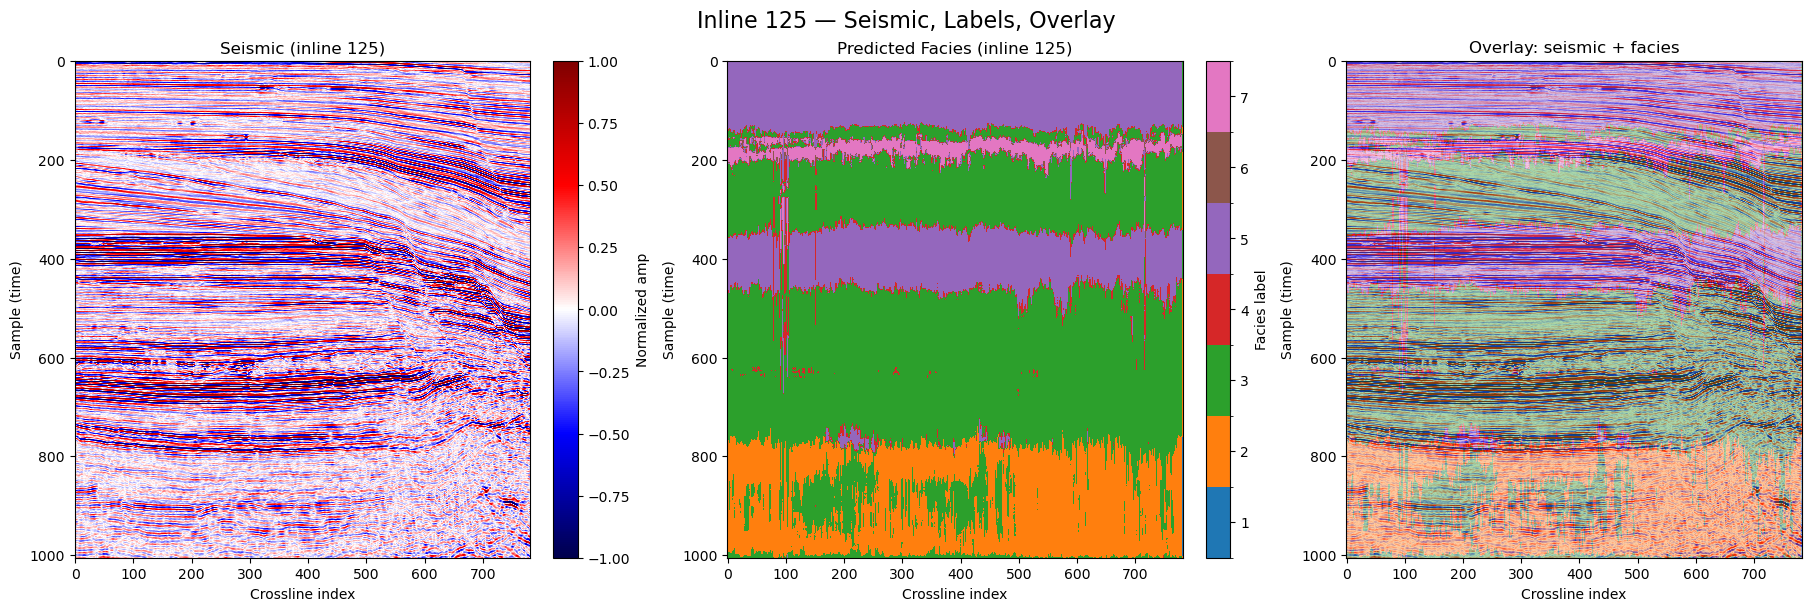

Saved figure: pred_facies_inline_125.png


In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from tqdm.notebook import tqdm

# ---------- CONFIG ----------
inline_to_plot = None   # None -> middle inline. Or set an int index to choose.
facies_npy = "facies_pred_cube.npy"

# ---------- 0. ensure test_cube exists ----------
if 'test_cube' not in globals():
    raise NameError("test_cube not found in memory. Run the cell that loads TestData_Image1.segy (read_segy) first.")

Nt, Ni, Nj = test_cube.shape[:3]
if inline_to_plot is None:
    iline_idx = Ni // 2
else:
    iline_idx = int(inline_to_plot)
    if not (0 <= iline_idx < Ni):
        raise IndexError(f"Requested inline {iline_idx} out of range (0..{Ni-1})")

# ---------- 1. obtain facies_pred ----------
if 'facies_pred' in globals():
    facies = facies_pred
    print("Using facies_pred from memory.")
elif os.path.exists(facies_npy):
    facies = np.load(facies_npy)
    print(f"Loaded facies predictions from '{facies_npy}'.")
else:
    # try to compute if model and features_test exist in memory
    if ('model' in globals()) and ('features_test' in globals()):
        print("facies_pred not found: will compute predictions using in-memory model & features_test (this may take time).")
        model_cpu = model  # model is expected to be on proper device already
        # move model to CPU for safety if device mismatch (optional)
        import torch
        device = next(model_cpu.parameters()).device
        model_cpu.eval()
        facies = np.zeros((Nt, Ni, Nj), dtype=np.int32)
        # compute in a safe loop (same patching used before)
        for i in tqdm(range(1, Ni-1), desc="Predict inlines"):
            for j in range(1, Nj-1):
                patch = features_test[:, i-1:i+2, j-1:j+2, :]  # (Nt,3,3,Lout)
                patch = np.transpose(patch, (0,3,1,2)).reshape(Nt, -1)  # (Nt, input_size)
                x = torch.from_numpy(patch[None,:,:].astype(np.float32)).to(device)
                with torch.no_grad():
                    logits = model_cpu(x)
                pred = logits.argmax(dim=2).cpu().numpy().ravel()
                facies[:, i, j] = pred + 1
        # save so next time loads quickly
        np.save(facies_npy, facies)
        print(f"Saved computed facies predictions to '{facies_npy}'.")
    else:
        raise NameError(
            "facies_pred not in memory and file 'facies_pred_cube.npy' not found. "
            "To proceed either:\n"
            "  • Run your prediction cell to produce `facies_pred` (or save to facies_pred_cube.npy), OR\n"
            "  • Ensure `model` and `features_test` exist in memory so this cell can compute predictions for you."
        )

# ---------- 2. basic sanity checks ----------
if facies.shape != (Nt, Ni, Nj):
    raise ValueError(f"facies shape {facies.shape} does not match test_cube shape {(Nt, Ni, Nj)}")

# ---------- 3. extract slices ----------
seis_inline = test_cube[:, iline_idx, :]   # (Nt, Nj)
lab_inline = facies[:, iline_idx, :]       # (Nt, Nj)

# ---------- 4. normalization for seismic display ----------
pmin, pmax = np.percentile(test_cube, [2, 98])
def norm_seis(arr):
    a = np.clip((arr - pmin) / (pmax - pmin), 0.0, 1.0)
    return a * 2.0 - 1.0

# ---------- 5. label colormap handling ----------
lab = lab_inline.copy()
lab_unique = np.unique(lab[~np.isnan(lab)])
if lab_unique.size == 0:
    raise ValueError("Label slice is empty or all NaN")
min_label = int(np.nanmin(lab_unique))
max_label = int(np.nanmax(lab_unique))

# if zero-based, convert to 1..N for plotting convenience
if min_label == 0:
    lab = lab + 1
    min_label += 1
    max_label += 1

num_classes = max_label - min_label + 1
color_list = [
    "#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd","#8c564b",
    "#e377c2","#7f7f7f","#bcbd22","#17becf"
]
if num_classes > len(color_list):
    cmap_labels = plt.get_cmap("tab20", num_classes)
else:
    cmap_labels = ListedColormap(color_list[:num_classes])
boundaries = np.arange(min_label, max_label+2) - 0.5
norm_labels = BoundaryNorm(boundaries=boundaries, ncolors=num_classes)

# ---------- 6. plotting ----------
fig, axs = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

ax = axs[0]
im0 = ax.imshow(norm_seis(seis_inline), cmap='seismic', aspect='auto', origin='upper')
ax.set_title(f"Seismic (inline {iline_idx})")
ax.set_xlabel("Crossline index")
ax.set_ylabel("Sample (time)")
plt.colorbar(im0, ax=ax, orientation='vertical', label='Normalized amp')

ax = axs[1]
im1 = ax.imshow(lab, cmap=cmap_labels, norm=norm_labels, aspect='auto', origin='upper')
ax.set_title(f"Predicted Facies (inline {iline_idx})")
ax.set_xlabel("Crossline index")
ax.set_ylabel("Sample (time)")
cbar = plt.colorbar(im1, ax=ax, ticks=np.arange(min_label, max_label+1))
cbar.ax.set_yticklabels([str(int(t)) for t in np.arange(min_label, max_label+1)])
cbar.set_label("Facies label")

ax = axs[2]
ax.imshow(norm_seis(seis_inline), cmap='seismic', aspect='auto', origin='upper')
ax.imshow(lab, cmap=cmap_labels, norm=norm_labels, aspect='auto', origin='upper', alpha=0.40)
ax.set_title("Overlay: seismic + facies")
ax.set_xlabel("Crossline index")
ax.set_ylabel("Sample (time)")

plt.suptitle(f"Inline {iline_idx} — Seismic, Labels, Overlay", fontsize=16)
plt.show()

# ---------- 7. save ----------
outname = f"pred_facies_inline_{iline_idx}.png"
fig.savefig(outname, dpi=200)
print("Saved figure:", outname)


Saved: ./seismic_inline_125.png


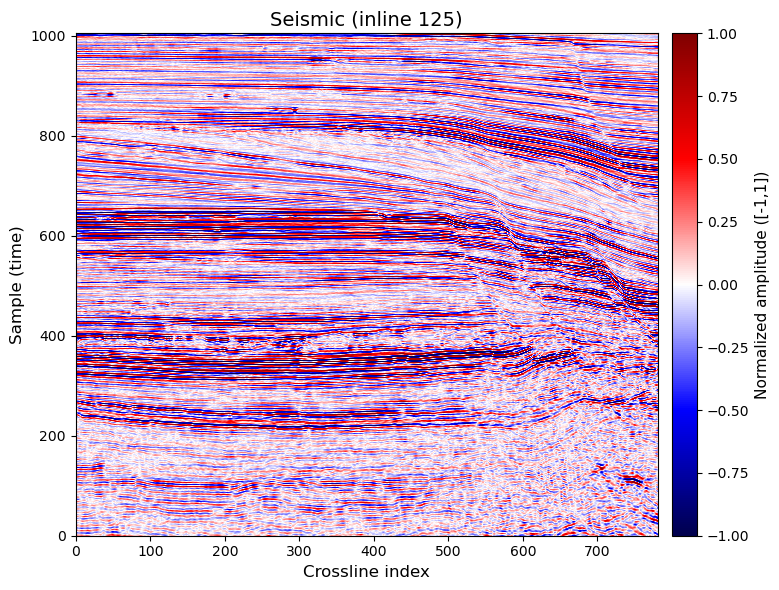

Saved: ./facies_inline_125.png


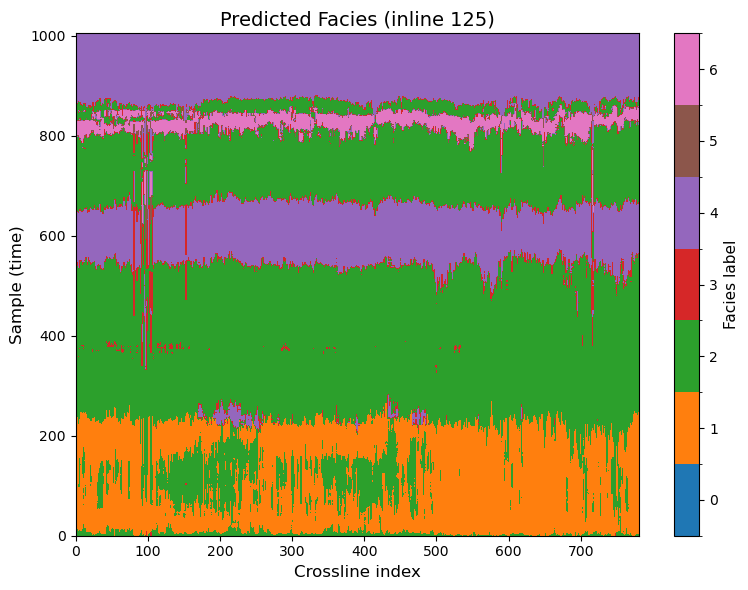

Saved: ./overlay_inline_125.png


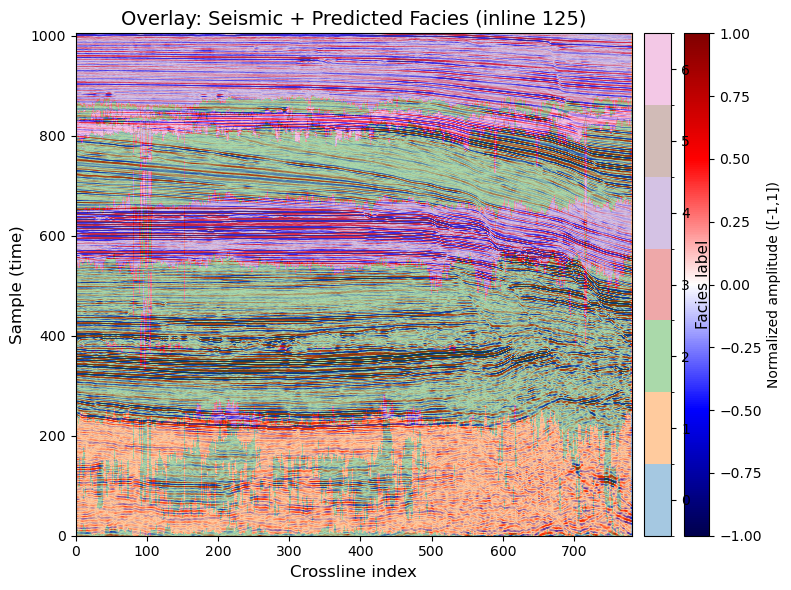

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import os

# ---------- CONFIG ----------
iline_idx = None       # None -> use middle inline. Or set an integer inline index.
alpha_overlay = 0.40   # transparency of facies overlay (0.0..1.0)
out_dir = "."          # change if you want a different folder
dpi = 200

# ---------- guard variables ----------
if 'test_cube' not in globals():
    raise NameError("test_cube not found. Load TestData_Image1.segy first (variable: test_cube).")

# prefer 'facies' if present, else facies_pred or load file
if 'facies' in globals():
    fac = facies
elif 'facies_pred' in globals():
    fac = facies_pred
elif os.path.exists("facies_pred_cube.npy"):
    fac = np.load("facies_pred_cube.npy")
else:
    raise NameError("Predicted facies not found in memory or file 'facies_pred_cube.npy'.")

Nt, Ni, Nj = test_cube.shape[:3]
if iline_idx is None:
    iline_idx = Ni // 2
else:
    iline_idx = int(iline_idx)
    if not (0 <= iline_idx < Ni):
        raise IndexError(f"iline_idx out of range (0..{Ni-1})")

# ---------- prepare slices ----------
seis = test_cube[:, iline_idx, :]    # (Nt, Nj)
lab = fac[:, iline_idx, :]           # (Nt, Nj)

# ---------- seismic normalization (robust) ----------
pmin, pmax = np.percentile(test_cube, [2, 98])
def norm_seis(arr):
    a = np.clip((arr - pmin) / (pmax - pmin), 0.0, 1.0)
    return a * 2.0 - 1.0  # scaled to [-1,1] so 'seismic' cmap centers at 0

# ---------- label colormap and normalization ----------
lab_int = lab.copy().astype(np.float32)
unique = np.unique(lab_int[~np.isnan(lab_int)])
if unique.size == 0:
    raise ValueError("Label slice appears empty (all NaN).")

min_label = int(np.nanmin(unique))
max_label = int(np.nanmax(unique))

# if zero-based labels convert to 1..N for nicer colorbar ticks
zero_based = (min_label == 0)
if zero_based:
    lab_int = lab_int + 1
    min_label += 1
    max_label += 1

num_classes = max_label - min_label + 1

# pick discrete colors (extend if >10)
color_list = [
    "#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd","#8c564b",
    "#e377c2","#7f7f7f","#bcbd22","#17becf"
]
if num_classes <= len(color_list):
    cmap_labels = ListedColormap(color_list[:num_classes])
else:
    cmap_labels = plt.get_cmap("tab20", num_classes)

boundaries = np.arange(min_label, max_label+2) - 0.5
norm_labels = BoundaryNorm(boundaries=boundaries, ncolors=num_classes)

# ---------- optionally convert sample index to time (if you know dt_ms) ----------
# dt_ms = 4.0  # <-- uncomment and set your sample interval in ms if you want time axis instead of sample index
use_time = False
if 'dt_ms' in globals():
    use_time = True
    t_axis = np.arange(Nt) * dt_ms
elif False:
    # If you prefer to set dt_ms manually, uncomment above and set dt_ms
    use_time = True

# prepare extent for imshow to show axes as [x0,x1,y1,y0] for time increasing downwards
if use_time:
    x0, x1 = 0, Nj-1
    y0, y1 = t_axis[0], t_axis[-1]
    extent = [x0, x1, y0, y1]
    y_label = "Time (ms)"
else:
    extent = [0, Nj-1, 0, Nt-1]
    y_label = "Sample (time)"

# ---------- 1) Seismic only ----------
fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(norm_seis(seis), cmap='seismic', aspect='auto', origin='upper', extent=extent)
ax.set_title(f"Seismic (inline {iline_idx})", fontsize=14)
ax.set_xlabel("Crossline index", fontsize=12)
ax.set_ylabel(y_label, fontsize=12)
cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label("Normalized amplitude ([-1,1])", fontsize=11)
plt.tight_layout()
outname1 = os.path.join(out_dir, f"seismic_inline_{iline_idx}.png")
fig.savefig(outname1, dpi=dpi)
print("Saved:", outname1)
plt.show()
plt.close(fig)

# ---------- 2) Facies only (discrete colorbar) ----------
fig, ax = plt.subplots(figsize=(8,6))
im2 = ax.imshow(lab_int, cmap=cmap_labels, norm=norm_labels, aspect='auto', origin='upper', extent=extent)
ax.set_title(f"Predicted Facies (inline {iline_idx})", fontsize=14)
ax.set_xlabel("Crossline index", fontsize=12)
ax.set_ylabel(y_label, fontsize=12)
cbar2 = fig.colorbar(im2, ax=ax, orientation='vertical', ticks=np.arange(min_label, max_label+1))
# set tick labels to original label numbering (1..N or 0..N-1 if you prefer)
tick_labels = [str(int(v - (1 if zero_based else 0))) for v in np.arange(min_label, max_label+1)]
cbar2.ax.set_yticklabels(tick_labels)
cbar2.set_label("Facies label", fontsize=11)
plt.tight_layout()
outname2 = os.path.join(out_dir, f"facies_inline_{iline_idx}.png")
fig.savefig(outname2, dpi=dpi)
print("Saved:", outname2)
plt.show()
plt.close(fig)

# ---------- 3) Overlay: seismic + facies ----------
fig, ax = plt.subplots(figsize=(8,6))
im0 = ax.imshow(norm_seis(seis), cmap='seismic', aspect='auto', origin='upper', extent=extent)
# colorbar for seismic (smaller)
cbar0 = fig.colorbar(im0, ax=ax, orientation='vertical', fraction=0.045, pad=0.02)
cbar0.set_label("Normalized amplitude ([-1,1])", fontsize=10)

# overlay facies
imf = ax.imshow(lab_int, cmap=cmap_labels, norm=norm_labels, aspect='auto', origin='upper', alpha=alpha_overlay, extent=extent)
ax.set_title(f"Overlay: Seismic + Predicted Facies (inline {iline_idx})", fontsize=14)
ax.set_xlabel("Crossline index", fontsize=12)
ax.set_ylabel(y_label, fontsize=12)

# add separate discrete colorbar for facies to the right
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.12)
cbarf = plt.colorbar(imf, cax=cax, ticks=np.arange(min_label, max_label+1))
cbarf.ax.set_yticklabels(tick_labels)
cbarf.set_label("Facies label", fontsize=11)

plt.tight_layout()
outname3 = os.path.join(out_dir, f"overlay_inline_{iline_idx}.png")
fig.savefig(outname3, dpi=dpi)
print("Saved:", outname3)
plt.show()
plt.close(fig)
